In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import scipy as sp
import matplotlib as mpl
import seaborn as sns

# Setting up Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

# Setting up Seaborn
sns.set_style("whitegrid")
#sns.set_context("poster")

%matplotlib inline

In [2]:
train = pd.read_csv('training_data.csv')
test = pd.read_csv('test_data.csv')

In [3]:
training = train.drop('status_group', axis=1)

In [4]:
training = training.drop('Unnamed: 0', axis=1)

test = test.drop('Unnamed: 0', axis=1)

In [5]:
##Plot function for Confusion Matrix

#plt.rcParams['figure.figsize'] = (6.0, 6.0)
from sklearn.metrics import confusion_matrix
labels=['functional','functional needs repair','non functional']
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(shrink=0.7)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, ha='right', fontsize=12)
    plt.yticks(tick_marks, labels , fontsize=12)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

## Because we are having maximum amount of Categorical data let us transform the features, and convert them into list

In [6]:
def transform_feature(df, column_name):
    unique_values = set(df[column_name].tolist())
    transformer_dict = {}
    for index, value in enumerate(unique_values):
        transformer_dict[value] = index
    df[column_name] = df[column_name].apply(lambda y: transformer_dict[y])
    return df

In [7]:
integer_columns = ['days_since_recorded', 'population','gps_height'] 
columns_to_transform = [col for col in training.columns if col not in integer_columns]
for column in columns_to_transform: 
    training = transform_feature(training, column)
    test = transform_feature(test, column)

In [8]:
## Now That we have Cleaned our dataset and Transformed our features, let us train our Model.

In [9]:
## Converting the Training dataframe into a matrix and predictor as y 
X = training.as_matrix()
y = train["status_group"].tolist()

> Splitting the Data Set with features into Train set  and Test set to train our model.

In [10]:
import sklearn.model_selection 
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, 
                                                                             y, 
                                                                             test_size = 0.3, 
                                                                             random_state = 0)

> As a part of EDA let us traing the data using different algorithms and findout which give us the better result.

The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability/robustness over a single estimator.

## Random Forest Classifier

In [11]:
import sklearn.ensemble

rfc = sklearn.ensemble.RandomForestClassifier(n_estimators=1000, 
                                              min_samples_split=6,
                                              criterion='gini', 
                                              max_features='auto',
                                              oob_score=True,
                                              random_state=1,
                                              n_jobs=-1)

In [12]:
rfc.fit(X_train, y_train)

print('Random Forest Classifier Train Accuracy Score :', rfc.score(X_train, y_train))
print('Random Forest Classifier Test Score :', rfc.score(X_test, y_test))

Random Forest Classifier Train Accuracy Score : 0.940163540164
Random Forest Classifier Test Score : 0.804826038159


In [13]:
print(rfc.feature_importances_)

[ 0.03115281  0.10641079  0.02993404  0.07896614  0.02576926  0.0383678
  0.09842102  0.05342271  0.01362311  0.03028696  0.04944368  0.01595152
  0.04169805  0.05324285  0.0433811   0.0145997   0.13042204  0.02934541
  0.01117207  0.06342844  0.04096049]


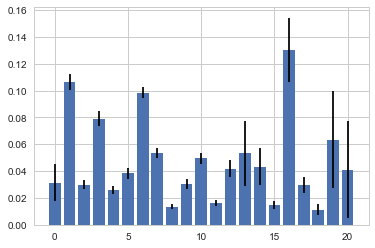

In [14]:
importance = rfc.feature_importances_
importance = pd.DataFrame(importance, index=training.columns, 
                          columns=["Importance"])

importance["Std"] = np.std([tree.feature_importances_ 
                            for tree in rfc.estimators_], axis=0)

x = range(importance.shape[0])
y = importance.iloc[:, 0]
yerr = importance.iloc[:, 1]
lables = list(training.columns.values)

ax = plt.bar(x, y, yerr=yerr ,align="center")

#plt.show()

In [15]:
list(training.columns.values)

['amount_tsh',
 'days_since_recorded',
 'funder',
 'gps_height',
 'installer',
 'basin',
 'subvillage',
 'population',
 'public_meeting',
 'scheme_management',
 'scheme_name',
 'permit',
 'construction_year',
 'extraction_type',
 'payment_type',
 'water_quality',
 'quantity_group',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group']

In [16]:
from sklearn.metrics import classification_report

In [17]:
predicted = rfc.predict(X_test)

In [18]:
report = classification_report(y_test, predicted)
print(report)

                         precision    recall  f1-score   support

             functional       0.79      0.90      0.84      9612
functional needs repair       0.64      0.28      0.39      1333
         non functional       0.84      0.77      0.81      6875

            avg / total       0.80      0.80      0.79     17820



Confusion matrix
[[8654  159  799]
 [ 760  375  198]
 [1512   50 5313]]


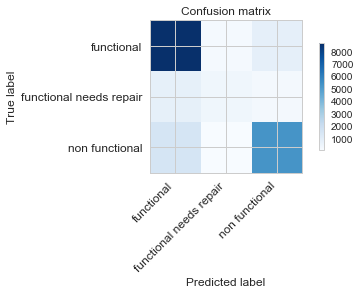

In [19]:
## Constructing the Confusion Matrix
cm = confusion_matrix(y_test, rfc.predict(X_test))
np.set_printoptions(precision=2)
print('Confusion matrix')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

## Decision Tree

In [20]:
from sklearn.tree import DecisionTreeClassifier

In [21]:
dtc = DecisionTreeClassifier(criterion='gini',
                            max_depth = 10,
                            max_features = 'auto',
                            random_state = 1,
                            splitter = 'best')

In [22]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best')

In [23]:
print("Train Score :", dtc.score(X_train, y_train))
print("Test Score :", dtc.score(X_test, y_test))

Train Score : 0.754545454545
Test Score : 0.733950617284


In [24]:
predt = dtc.predict(X_test)
report = classification_report(y_test, predt)
print(report)

                         precision    recall  f1-score   support

             functional       0.70      0.92      0.80      9612
functional needs repair       0.47      0.06      0.11      1333
         non functional       0.82      0.61      0.70      6875

            avg / total       0.73      0.73      0.71     17820



Confusion matrix
[[8825   43  744]
 [1055   84  194]
 [2652   53 4170]]


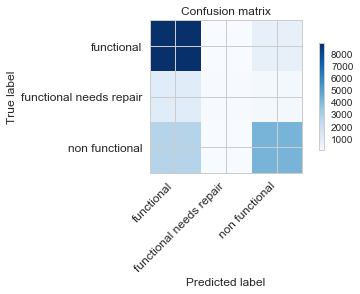

In [25]:
## Constructing the Confusion Matrix
cm = confusion_matrix(y_test, dtc.predict(X_test))
np.set_printoptions(precision=2)
print('Confusion matrix')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

## Extra Tree Classifier

In [26]:
from sklearn.ensemble import ExtraTreesClassifier

ETC = ExtraTreesClassifier(n_estimators=1000,min_samples_split=10)

In [27]:
ETC.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [28]:
print('Extra Tree Classifier Training Score :',ETC.score(X_train, y_train))
print('Extra Tree Classifier Test Score :',ETC.score(X_test, y_test))

Extra Tree Classifier Training Score : 0.911135161135
Extra Tree Classifier Test Score : 0.802974186308


In [29]:
etcpredicted = ETC.predict(X_test)
report = classification_report(y_test, etcpredicted)
print(report)

                         precision    recall  f1-score   support

             functional       0.79      0.90      0.84      9612
functional needs repair       0.65      0.29      0.40      1333
         non functional       0.84      0.76      0.80      6875

            avg / total       0.80      0.80      0.79     17820



Confusion matrix
[[8673  158  781]
 [ 737  381  215]
 [1571   49 5255]]


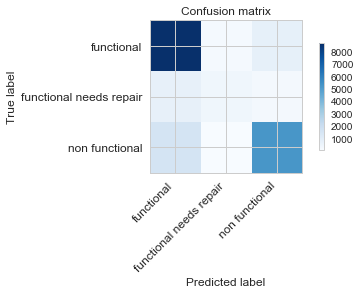

In [30]:
## Constructing the Confusion Matrix
cm = confusion_matrix(y_test, etcpredicted)
np.set_printoptions(precision=2)
print('Confusion matrix')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

## Linear Search CV

In [31]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [32]:
pipe = Pipeline([('scl', StandardScaler()), ('clf', LinearSVC())])

In [33]:
param_grid = {'clf__C':[0.01],
                      'clf__class_weight':[None]}

In [34]:
estimator = GridSearchCV(estimator=pipe,
                                 param_grid=param_grid,
                                 n_jobs=-1)

In [35]:
estimator.fit(X_train, y_train)

/Users/krk9037/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/krk9037/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/krk9037/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/krk9037/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'clf__C': [0.01], 'clf__class_weight': [None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [36]:
#print(estimator.score(X_test,y_train))

print('Linear Search CV Training Score :',estimator.score(X_train, y_train))
print('Linear Search CV Test Score :',estimator.score(X_test, y_test))

Linear Search CV Training Score : 0.67190957191
Linear Search CV Test Score : 0.674691358025


/Users/krk9037/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


## Gradient Boosting

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [38]:
test_id = pd.read_csv('SubmissionFormat.csv')
test_id.columns = ['idd', 'status_group']
test_id = test_id.idd

In [30]:
def model(X_train, X_test, y_train, y_test, test):
    if __name__ == '__main__':
    
        param_grid = {'learning_rate': [0.075,0.07],
                      'max_depth': [6,7],
                      'min_samples_leaf': [7,8],
                      'max_features': [1.0],
                      'n_estimators':[100, 200]}                      

        gbc = GridSearchCV(estimator=GradientBoostingClassifier(),
                                 param_grid=param_grid,
                                 n_jobs=-1)

        gbc.fit(X_train, y_train)

        best_params = gbc.best_params_

        print (best_params)
                                 
        validation_accuracy = gbc.score(X_test, y_test)
        print('Validation accuracy: ', validation_accuracy)
        
        predictions = gbc.predict(test)
        
        data = {'ID': test_id, 'status_group': predictions}

        submit = pd.DataFrame(data=data)

        vals_to_replace = {2:'functional', 1:'functional needs repair',
                           0:'non functional'}

        submit.status_group = submit.status_group.replace(vals_to_replace)        

        submit.to_csv('pump_predictions.csv', index=False)

In [40]:
model(X_train, X_test, y_train, y_test, test)

{'learning_rate': 0.075, 'max_depth': 7, 'max_features': 1.0, 'min_samples_leaf': 8, 'n_estimators': 200}
Validation accuracy:  0.793714927048


## Predictions

In [39]:
predict = ETC.predict(test)

In [40]:
submission = pd.read_csv('SubmissionFormat.csv')

In [41]:
Final_merge = pd.concat([test, submission], axis=1)

In [42]:
Final_merge.head()

,amount_tsh,days_since_recorded,funder,gps_height,installer,basin,subvillage,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,payment_type,water_quality,quantity_group,source_type,source_class,waterpoint_type,waterpoint_type_group,id,status_group
0,0,302,9,1996,9,0,4965,321,2,2,0,2,4,1,0,7,0,4,2,6,5,50785,predicted label
1,0,302,6,1569,6,8,3533,300,2,0,1399,2,6,9,0,7,4,2,1,1,1,51630,predicted label
2,0,305,9,1567,9,0,3806,500,2,0,1604,1,4,1,0,7,4,4,2,6,5,17168,predicted label
3,0,315,9,267,9,2,3966,250,1,0,0,2,2,1,4,7,1,1,1,6,5,45559,predicted label
4,65,251,9,1260,9,2,3386,60,1,3,1668,2,6,9,3,7,3,2,1,1,1,49871,predicted label


In [43]:
Final_merge['status_group'] = predict

In [44]:
Final_merge[['id','status_group']].to_csv('submission.csv', index=False)

In [45]:
sub = pd.read_csv('submission.csv')

In [46]:
sub.head()

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,non functional
3,45559,non functional
4,49871,functional


In [47]:
sub.status_group.value_counts()

functional                 9716
non functional             5015
functional needs repair     119
Name: status_group, dtype: int64